In [1]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import shutil
import random

# 1. Mount Google Drive (essential for a new notebook)
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# 2. Define your original Pascal VOC dataset base path (source for images and annotations)
# This should point to where your original 'my_galapagos_seals_dataset' folder is unzipped.
# Based on our previous setup, it's likely still here in the Colab temporary storage.
original_unzip_base_path = '/content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset'
original_annotations_dir = os.path.join(original_unzip_base_path, 'Annotations')

# Verify the original dataset path (optional, but good for debugging if issues arise)
if not os.path.exists(original_unzip_base_path):
    print(f"Warning: Original dataset not found at {original_unzip_base_path}. Please ensure it is unzipped.")
    # If it's not there, you might need to re-unzip it for this step.
    # We can add unzipping logic here if needed, but assuming it was done in a prior run and is still available.
    # For a fresh notebook, if your original zip is on Drive, you might need this:
    # zip_file_path = '/content/drive/My Drive/galapagos_seals_annotated_data/my_galapagos_seals_dataset.zip'
    # shutil.unpack_archive(zip_file_path, '/content/galapagos_seals_annotated_data/')


# 3. Define the ROOT directory for your NEW VGG16-specific dataset on Google Drive
# We'll create a dedicated folder for the cropped images
VGG16_DATA_ROOT = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset')

# 4. Define your class names (must match your dataset's class names in XMLs)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis",
    "Zalophus_wollebaeki"
]

# 5. Define target image size for VGG16 (standard for ImageNet pre-trained models)
TARGET_IMG_SIZE = (224, 224)

print(f"\nPreparing VGG16 dataset for classes: {CLASS_NAMES}")
print(f"Cropped images will be resized to: {TARGET_IMG_SIZE}")
print(f"New dataset will be saved to: {VGG16_DATA_ROOT}")


# --- Cleanup previous VGG16 data if it exists for a fresh start ---
if os.path.exists(VGG16_DATA_ROOT):
    print(f"Cleaning up existing VGG16 data root: {VGG16_DATA_ROOT}")
    shutil.rmtree(VGG16_DATA_ROOT)
    print("Clean up complete.")

# 6. Create necessary directories for the VGG16 classification dataset
# Structure: VGG16_DATA_ROOT/split/class_name/image.jpg
for split_folder in ['train', 'val', 'test']:
    for class_name in CLASS_NAMES:
        os.makedirs(os.path.join(VGG16_DATA_ROOT, split_folder, class_name), exist_ok=True)
print("\nCreated VGG16 dataset structure on Drive.")


# Function to process and crop images
def process_and_crop_dataset(original_base_path, original_annotations_dir, vgg16_data_root, class_names, target_size):
    split_map = {
        'train': 'train',
        'validation': 'val', # Map original 'validation' to 'val'
        'test': 'test'
    }

    class_counts = {name: 0 for name in class_names}
    total_cropped_images = 0

    for original_split_name, vgg16_split_name in split_map.items():
        original_split_dir = os.path.join(original_base_path, original_split_name)
        print(f"\nProcessing original '{original_split_name}' split for VGG16 '{vgg16_split_name}'...")

        # Collect all image paths for this split, regardless of class subfolder
        image_paths = []
        for class_subfolder in os.listdir(original_split_dir):
            class_subfolder_path = os.path.join(original_split_dir, class_subfolder)
            if os.path.isdir(class_subfolder_path):
                for img_name in os.listdir(class_subfolder_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(os.path.join(class_subfolder_path, img_name))
        random.shuffle(image_paths) # Shuffle to process in a random order

        processed_for_split = 0
        for image_path in image_paths:
            img_filename = os.path.basename(image_path)
            annotation_filename = os.path.splitext(img_filename)[0] + '.xml'
            annotation_filepath = os.path.join(original_annotations_dir, annotation_filename)

            if not os.path.exists(annotation_filepath):
                # print(f"  Skipping {img_filename}: No annotation file found for cropping.")
                continue

            try:
                img = Image.open(image_path).convert('RGB') # Ensure RGB for VGG16
                tree = ET.parse(annotation_filepath)
                root = tree.getroot()

                for obj in root.iter('object'):
                    label = obj.find('name').text
                    if label not in class_names:
                        print(f"  Warning: Unknown label '{label}' in {annotation_filename}. Skipping object for VGG16 dataset.")
                        continue

                    xml_box = obj.find('bndbox')
                    xmin = int(float(xml_box.find('xmin').text))
                    ymin = int(float(xml_box.find('ymin').text))
                    xmax = int(float(xml_box.find('xmax').text))
                    ymax = int(float(xml_box.find('ymax').text))

                    # Ensure valid coordinates
                    if not (xmin < xmax and ymin < ymax):
                        print(f"  Warning: Invalid bounding box in {annotation_filename} for label '{label}'. Skipping crop.")
                        continue

                    # Crop the image
                    # Ensure coordinates are within image bounds
                    img_width, img_height = img.size
                    xmin = max(0, xmin)
                    ymin = max(0, ymin)
                    xmax = min(img_width, xmax)
                    ymax = min(img_height, ymax)

                    cropped_img = img.crop((xmin, ymin, xmax, ymax))

                    # Resize the cropped image
                    cropped_img_resized = cropped_img.resize(target_size, Image.Resampling.LANCZOS) # Use LANCZOS for high quality downsampling

                    # Save the cropped image to the VGG16 dataset structure
                    output_dir = os.path.join(vgg16_data_root, vgg16_split_name, label)
                    output_filename = f"{os.path.splitext(img_filename)[0]}_{obj.find('name').text}_{random.randint(1000, 9999)}.jpg" # Unique filename
                    output_path = os.path.join(output_dir, output_filename)
                    cropped_img_resized.save(output_path)

                    class_counts[label] += 1
                    total_cropped_images += 1
                    processed_for_split += 1

            except Exception as e:
                print(f"  Error processing image {img_filename} or annotation {annotation_filename} for VGG16: {e}")

        print(f"  Processed {processed_for_split} object instances for '{original_split_name}' split.")

    print(f"\nTotal cropped images created for VGG16 dataset: {total_cropped_images}")
    print("Class distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} images")


# Run the data preparation process
process_and_crop_dataset(original_unzip_base_path, original_annotations_dir, VGG16_DATA_ROOT, CLASS_NAMES, TARGET_IMG_SIZE)

# --- Verification ---
print("\nVerifying VGG16 dataset structure:")
for split_folder in ['train', 'val', 'test']:
    for class_name in CLASS_NAMES:
        path = os.path.join(VGG16_DATA_ROOT, split_folder, class_name)
        if os.path.exists(path):
            num_files = len(os.listdir(path))
            print(f"  {split_folder}/{class_name}: {num_files} images")
        else:
            print(f"  {split_folder}/{class_name}: Path does not exist.")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!

Preparing VGG16 dataset for classes: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']
Cropped images will be resized to: (224, 224)
New dataset will be saved to: /content/drive/My Drive/vgg16_seals_classification_dataset

Created VGG16 dataset structure on Drive.

Processing original 'train' split for VGG16 'train'...
  Processed 379 object instances for 'train' split.

Processing original 'validation' split for VGG16 'val'...
  Processed 64 object instances for 'validation' split.

Processing original 'test' split for VGG16 'test'...
  Processed 54 object instances for 'test' split.

Total cropped images created for VGG16 dataset: 497
Class distribution:
  Arctocephalus_galapagoensis: 47 images
  Zalophus_wollebaeki: 450 images

Verifying VGG16 dataset structure:
  train/Arctocephalus_galapagoensis: 38 images
  train/Zalophus_wollebaeki: 341 images
  val/Arctocephalus_galapagoensis: 4 images
 

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 1. Mount Google Drive (essential for a new notebook or re-running in a fresh session)
print("Mounting Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# 2. Define the ROOT directory for your VGG16-specific dataset on Google Drive
VGG16_DATA_ROOT = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset')

# Verify that the dataset exists (optional, but good practice)
if not os.path.exists(VGG16_DATA_ROOT):
    print(f"Error: VGG16 dataset not found at {VGG16_DATA_ROOT}.")
    print("Please ensure the 'Phase 1: Data Preparation for VGG16' cell was run successfully.")
    # You might want to halt execution here or add re-creation logic if this is critical.

# 3. Define dataset paths for training, validation, and test splits
TRAIN_DIR = os.path.join(VGG16_DATA_ROOT, 'train')
VAL_DIR = os.path.join(VGG16_DATA_ROOT, 'val')
TEST_DIR = os.path.join(VGG16_DATA_ROOT, 'test')

# 4. Define your class names (must match the folder names in your dataset)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis",
    "Zalophus_wollebaeki"
]
NUM_CLASSES = len(CLASS_NAMES)
TARGET_IMG_SIZE = (224, 224) # VGG16's expected input size
BATCH_SIZE = 32 # Common batch size, adjust based on GPU memory

print(f"\nTraining VGG16 model for {NUM_CLASSES} classes: {CLASS_NAMES}")
print(f"Using dataset from: {VGG16_DATA_ROOT}")


# 5. Data Generators for training, validation, and testing
# We'll apply basic resizing and preprocessing for VGG16
# For the control case, no specific balancing techniques applied here yet.

# VGG16 expects pixel values to be in the range of its ImageNet pre-training (0-255 scaled by mean/std)
# or 0-1 scaled by 1/255. Keras applications have built-in preprocessing functions.
# Here, we'll just rescale to 0-1, as VGG16's internal preprocess_input handles the rest.
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For 2+ classes
    classes=CLASS_NAMES, # Ensure correct order
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False # No need to shuffle test data
)

print("\nData generators created.")
print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {val_generator.samples} validation images belonging to {val_generator.num_classes} classes.")
print(f"Found {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")


# 6. Build the VGG16 Model for Transfer Learning
# Load VGG16 pre-trained on ImageNet, without its top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(TARGET_IMG_SIZE[0], TARGET_IMG_SIZE[1], 3))

# Freeze the convolutional base to train only the new layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head on top of the base model
x = base_model.output
x = Flatten()(x) # Flatten the output from the convolutional base
x = Dense(256, activation='relu')(x) # A dense layer
x = Dropout(0.5)(x) # Dropout for regularization
predictions = Dense(NUM_CLASSES, activation='softmax')(x) # Output layer for 2 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# 7. Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', # Use categorical_crossentropy for one-hot encoded labels
              metrics=['accuracy'])

model.summary()

# 8. Define Callbacks for training
# ModelCheckpoint to save the best model weights based on validation accuracy
model_checkpoint_path = os.path.join(
    '/content/drive/My Drive',
    'vgg16_training_results', # New folder for VGG16 results on Drive
    'vgg16_classification_control_case', # Subfolder for this specific experiment
    'best_model.h5' # File name for the best model
)
os.makedirs(os.path.dirname(model_checkpoint_path), exist_ok=True) # Ensure path exists

checkpoint = ModelCheckpoint(
    model_checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping to stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10, # Number of epochs with no improvement after which training will be stopped.
    mode='max',
    verbose=1
)

# ReduceLROnPlateau to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.000001, # Lower bound on the learning rate.
    mode='max',
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# 9. Train the Model
EPOCHS_VGG16 = 50 # Start with 50 epochs

print("\nStarting VGG16 model training (Control Case)...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_VGG16,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

print("\nVGG16 Training (Control Case) complete!")
print(f"Best model saved to: {model_checkpoint_path}")

# Optional: Evaluate on test set after training
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!

Training VGG16 model for 2 classes: ['Arctocephalus_galapagoensis', 'Zalophus_wollebaeki']
Using dataset from: /content/drive/My Drive/vgg16_seals_classification_dataset
Found 379 images belonging to 2 classes.
Found 64 images belonging to 2 classes.
Found 54 images belonging to 2 classes.

Data generators created.
Found 379 training images belonging to 2 classes.
Found 64 validation images belonging to 2 classes.
Found 54 test images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Starting VGG16 model training (Control Case)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7719 - loss: 0.7431 
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to /content/drive/My Drive/vgg16_training_results/vgg16_classification_control_case/best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 264s 24s/step - accuracy: 0.7789 - loss: 0.7314 - val_accuracy: 0.9375 - val_loss: 0.2365 - learning_rate: 1.0000e-04
Epoch 2/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 3:37 22s/step - accuracy: 0.9062 - loss: 0.3155

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.93750
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.9062 - loss: 0.3155 - val_accuracy: 0.9375 - val_loss: 0.2757 - learning_rate: 1.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.8785 - loss: 0.3221 
Epoch 3: val_accuracy did not improve from 0.93750
11/11 ━━━━━━━━━━━━━━━━━━━━ 258s 24s/step - accuracy: 0.8795 - loss: 0.3201 - val_accuracy: 0.9375 - val_loss: 0.2282 - learning_rate: 1.0000e-04
Epoch 4/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 3:12 19s/step - accuracy: 0.8750 - loss: 0.4132
Epoch 4: val_accuracy did not improve from 0.93750
11/11 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.8750 - loss: 0.4132 - val_accuracy: 0.9375 - val_loss: 0.2183 - learning_rate: 1.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9166 - loss: 0.1836 
Epoch 5: val_accuracy did not improve from 0.93750
11/11 ━━━━━━━━━━━━━━━━━━━━ 257s 24s/step - accuracy: 0.9166 - loss: 0.1851 - val_accuracy: 0.9375 - val_loss

Loading best model from: /content/drive/My Drive/vgg16_training_results/vgg16_classification_control_case/best_model.h5


Found 54 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Found 54 test images belonging to 2 classes.

Evaluating model on the test set for detailed metrics...
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 15s/step

--- Classification Report ---
                             precision    recall  f1-score   support

Arctocephalus_galapagoensis       0.00      0.00      0.00         5
        Zalophus_wollebaeki       0.91      1.00      0.95        49

                   accuracy                           0.91        54
                  macro avg       0.45      0.50      0.48        54
               weighted avg       0.82      0.91      0.86        54

Classification report saved to: /content/drive/My Drive/vgg16_training_results/vgg16_classification_control_case/classification_report.txt

--- Confusion Matrix ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


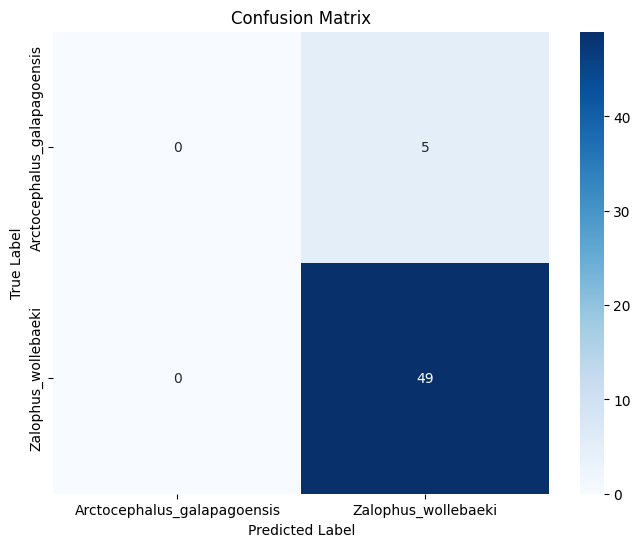

Confusion matrix plot saved to: /content/drive/My Drive/vgg16_training_results/vgg16_classification_control_case/confusion_matrix.png

Saving training history...
Training history saved to: /content/drive/My Drive/vgg16_training_results/vgg16_classification_control_case/training_history.json


<Figure size 640x480 with 0 Axes>

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For nicer confusion matrix plots
import json # To save history object

# --- 1. Define Paths (Ensure Google Drive is mounted) ---
# Assuming Google Drive is already mounted from previous cells.
# If not, run: from google.colab import drive; drive.mount('/content/drive')

VGG16_DATA_ROOT = os.path.join('/content/drive/My Drive', 'vgg16_seals_classification_dataset')

# Path to the saved best model (Control Case)
MODEL_SAVE_DIR = os.path.join(
    '/content/drive/My Drive',
    'vgg16_training_results',
    'vgg16_classification_control_case' # Your specific run folder
)
BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_model.h5')

# Define test dataset path
TEST_DIR = os.path.join(VGG16_DATA_ROOT, 'test')

# Define class names (must match the folder names and order during training)
CLASS_NAMES = [
    "Arctocephalus_galapagoensis",
    "Zalophus_wollebaeki"
]
NUM_CLASSES = len(CLASS_NAMES)
TARGET_IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- 2. Load the Best Trained Model ---
if os.path.exists(BEST_MODEL_PATH):
    print(f"Loading best model from: {BEST_MODEL_PATH}")
    model = load_model(BEST_MODEL_PATH)
else:
    print(f"Error: Model not found at {BEST_MODEL_PATH}. Please ensure training completed successfully.")
    # Exit or handle error

# --- 3. Prepare Test Data Generator ---
test_datagen = ImageDataGenerator(rescale=1./255) # Same preprocessing as training
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False # IMPORTANT: Do NOT shuffle test data for consistent evaluation
)

print(f"\nFound {test_generator.samples} test images belonging to {test_generator.num_classes} classes.")

# --- 4. Evaluate and Get Predictions ---
print("\nEvaluating model on the test set for detailed metrics...")

# Get true labels and predicted probabilities
Y_pred_proba = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + (test_generator.samples % BATCH_SIZE != 0))
Y_pred_classes = np.argmax(Y_pred_proba, axis=1) # Convert probabilities to class indices

# Get true class labels (indices)
# The order of labels from flow_from_directory is consistent with the test_generator.classes
Y_true = test_generator.classes[test_generator.index_array] # This extracts the true labels in the correct order

# --- 5. Generate and Print Classification Report ---
print("\n--- Classification Report ---")
report = classification_report(Y_true, Y_pred_classes, target_names=CLASS_NAMES)
print(report)

# Save Classification Report to Drive
report_filepath = os.path.join(MODEL_SAVE_DIR, 'classification_report.txt')
with open(report_filepath, 'w') as f:
    f.write(report)
print(f"Classification report saved to: {report_filepath}")

# --- 6. Generate and Plot Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save Confusion Matrix plot to Drive
cm_filepath = os.path.join(MODEL_SAVE_DIR, 'confusion_matrix.png')
plt.savefig(cm_filepath)
print(f"Confusion matrix plot saved to: {cm_filepath}")

# --- 7. Save Training History (if available from previous run) ---
# Assuming 'history' object was returned by model.fit() in the training cell
# You would need to make sure the 'history' object is accessible here.
# If you run this code *after* the training cell in the same session, it will be.
# If you run this in a *new* session, you would need to load the training logs if saved.
# For simplicity, we'll assume this is run directly after training or you load the history.

# Example to save a dummy history if it's not available (replace with actual if running in new session)
# In your training cell, you should add:
# import json
# history_dict = history.history
# history_filepath = os.path.join(MODEL_SAVE_DIR, 'training_history.json')
# with open(history_filepath, 'w') as f:
#     json.dump(history_dict, f)

# For current execution, if 'history' object is not available, we can't save it directly.
# If you want to save it, ensure the 'history = model.fit(...)' line from the previous cell is accessible.
# Or load it back if you saved it.
# As a demonstration of saving:
if 'history' in locals(): # Check if 'history' object exists in the current scope
    print("\nSaving training history...")
    history_dict = history.history
    history_filepath = os.path.join(MODEL_SAVE_DIR, 'training_history.json')
    with open(history_filepath, 'w') as f:
        json.dump(history_dict, f)
    print(f"Training history saved to: {history_filepath}")
else:
    print("\n'history' object not found. Run this code in the same session after model.fit() to save history.")
    print("Or load previously saved history if available.")